<a href="https://colab.research.google.com/github/ctorney/learning-to-simulate-tf2/blob/main/test-files/AccelerationSpektralModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spektral

In [ ]:
#@title ### Imports { form-width: "30%" }
#@markdown TODO: -Normalise velocity/acceleration data

import os, sys
import numpy as np
from math import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import datetime

import tensorflow as tf

from scipy import stats

import pickle

import functools
from tqdm import tqdm

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from spektral.layers import ECCConv, GlobalAvgPool, MessagePassing, XENetConv, GlobalAttentionPool, GlobalMaxPool, GlobalSumPool,GlobalAttnSumPool


plt.style.use('ggplot')
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid')

# Generate Data

In [ ]:
#@title ### Zonal Model { form-width: "30%" }

def get_record(group_id,pos,vel,acc):
    feature = { 'group_id': tf.train.Feature(int64_list=tf.train.Int64List(value=[group_id])),
                'pos': tf.train.Feature(bytes_list=tf.train.BytesList(value=[pos.numpy()])),
                'vel': tf.train.Feature(bytes_list=tf.train.BytesList(value=[vel.numpy()])),
                'acc': tf.train.Feature(bytes_list=tf.train.BytesList(value=[acc.numpy()]))
                }
    return tf.train.Example(features=tf.train.Features(feature=feature))


class zonal_model:
    def __init__(self, N, timesteps, discard, repeat, L, dt, save_interval,train_directory='train_datasets', valid_directory='valid_datasets', disable_progress=False):
        self.N = N
        self.timesteps = timesteps
        self.discard = discard
        self.B = repeat  # repeat for B batches
        self.L = L
        self.dt = dt
        self.save_interval = save_interval
        
        self.micro_state = np.zeros((self.B, (self.timesteps - self.discard)//self.save_interval, N, 4),dtype=np.float32)

        self.sim_counter=0

        if not os.path.exists(train_directory):
            os.makedirs(train_directory)

        if not os.path.exists(valid_directory):
            os.makedirs(valid_directory)

        self.train_directory = train_directory
        self.valid_directory = valid_directory

        # turn progress bar on or off
        self.disable_progress = disable_progress

        self.valid_fraction = 0.1
        
    def initialise_state(self):

        #self.positions = tf.random.uniform((self.B,self.N,2),0.5*self.L, 0.5*self.L+20) #0,self.L)
        self.positions = tf.random.uniform((self.B,self.N,2),0, self.L) 
        self.angles = tf.random.uniform((self.B,self.N,1), 0, 2*pi) #
        


    def run_sim(self, *params):

        eta, Ra, Ro, Rr, vs, va, sigma = params
        
        record_file = self.train_directory + '/microstates-' + str(self.sim_counter) + '.tfrecords'
        self.writer = tf.io.TFRecordWriter(record_file) 
        
        valid_file = self.valid_directory + '/microstates-' + str(self.sim_counter) + '.tfrecords'
        self.validwriter = tf.io.TFRecordWriter(valid_file) 
        
        # tensorflow function to run an update step
        @tf.function
        def update_tf(X, A):
            cos_A = tf.math.cos(A)
            sin_A = tf.math.sin(A)


            Xx = tf.expand_dims(X[...,0],-1)
            dx = -Xx + tf.linalg.matrix_transpose(Xx)
            dx = tf.where(dx>0.5*self.L, dx-self.L, dx)
            dx = tf.where(dx<-0.5*self.L, dx+self.L, dx)

            Xy = tf.expand_dims(X[...,1],-1)
            dy = -Xy + tf.linalg.matrix_transpose(Xy)
            dy = tf.where(dy>0.5*self.L, dy-self.L, dy)
            dy = tf.where(dy<-0.5*self.L, dy+self.L, dy)


            angle_to_neigh = tf.math.atan2(dy, dx)
            cos_N = tf.math.cos(angle_to_neigh)
            sin_N = tf.math.sin(angle_to_neigh)
            rel_angle_to_neigh = angle_to_neigh - A
            rel_angle_to_neigh = tf.math.atan2(tf.math.sin(rel_angle_to_neigh), tf.math.cos(rel_angle_to_neigh))
            
            dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))
    
            # repulsion 
            rep_x = tf.where(dist<=Rr, -dx, tf.zeros_like(dx))
            rep_x = tf.where(rel_angle_to_neigh<0.5*va, rep_x, tf.zeros_like(rep_x))
            rep_x = tf.where(rel_angle_to_neigh>-0.5*va, rep_x, tf.zeros_like(rep_x))
            rep_x = tf.math.divide_no_nan(rep_x,tf.math.square(dist))
            rep_x = tf.reduce_sum(rep_x,axis=2)

            rep_y = tf.where(dist<=Rr, -dy, tf.zeros_like(dy))
            rep_y = tf.where(rel_angle_to_neigh<0.5*va, rep_y, tf.zeros_like(rep_y))
            rep_y = tf.where(rel_angle_to_neigh>-0.5*va, rep_y, tf.zeros_like(rep_y))
            rep_y = tf.math.divide_no_nan(rep_y,tf.math.square(dist))
            rep_y = tf.reduce_sum(rep_y,axis=2)

            # alignment 
            align_x = tf.where(dist<=Ro, cos_A, tf.zeros_like(cos_A))
            align_x = tf.where(rel_angle_to_neigh<0.5*va, align_x, tf.zeros_like(align_x))
            align_x = tf.where(rel_angle_to_neigh>-0.5*va, align_x, tf.zeros_like(align_x))
            align_x = tf.reduce_sum(align_x,axis=1)
            
            align_y = tf.where(dist<=Ro, sin_A, tf.zeros_like(sin_A))
            align_y = tf.where(rel_angle_to_neigh<0.5*va, align_y, tf.zeros_like(align_y))
            align_y = tf.where(rel_angle_to_neigh>-0.5*va, align_y, tf.zeros_like(align_y))
            align_y = tf.reduce_sum(align_y,axis=1)

            al_norm = tf.math.sqrt(align_x**2+align_y**2)
            align_x = tf.math.divide_no_nan(align_x,al_norm)
            align_y = tf.math.divide_no_nan(align_y,al_norm)

            # attractive interactions
            attr_x = tf.where(dist<=Ra, dx, tf.zeros_like(dx))
            attr_x = tf.where(rel_angle_to_neigh<0.5*va, attr_x, tf.zeros_like(attr_x))
            attr_x = tf.where(rel_angle_to_neigh>-0.5*va, attr_x, tf.zeros_like(attr_x))
            attr_x = tf.reduce_sum(attr_x,axis=2)

            attr_y = tf.where(dist<=Ra, dy, tf.zeros_like(dy))
            attr_y = tf.where(rel_angle_to_neigh<0.5*va, attr_y, tf.zeros_like(attr_y))
            attr_y = tf.where(rel_angle_to_neigh>-0.5*va, attr_y, tf.zeros_like(attr_y))
            attr_y = tf.reduce_sum(attr_y,axis=2)

            at_norm = tf.math.sqrt(attr_x**2+attr_y**2)
            attr_x = tf.math.divide_no_nan(attr_x,at_norm)
            attr_y = tf.math.divide_no_nan(attr_y,at_norm)

            # combine angles and convert to desired angle change
            social_x = rep_x + align_x + attr_x
            social_y = rep_y + align_y + attr_y

            d_angle = tf.math.atan2(social_y,social_x)
            d_angle = tf.expand_dims(d_angle,-1)

            
            d_angle = tf.math.atan2((1-eta)*tf.math.sin(d_angle) + eta*sin_A, (1-eta)*tf.math.cos(d_angle) + eta*cos_A)

            d_angle = d_angle - A
            d_angle = tf.where(d_angle>pi, d_angle-2*pi, d_angle)
            d_angle = tf.where(d_angle<-pi, d_angle+2*pi, d_angle)


            # add perception noise
            noise = tf.random.normal(shape=(self.B,self.N,1),mean=0,stddev=sigma*(self.dt**0.5))
            d_angle = d_angle + noise
            
            # restrict to maximum turning angle
            #d_angle = tf.where(tf.math.abs(d_angle)>eta*self.dt, tf.math.sign(d_angle)*eta*self.dt, d_angle)
            
            # rotate headings
            A = A + d_angle
            
            # update positions
            velocity = self.dt*vs*tf.concat([tf.cos(A),tf.sin(A)],axis=-1)
            X += velocity

            # add periodic boundary conditions
            A = tf.where(A<-pi,  A+2*pi, A)
            A = tf.where(A>pi, A-2*pi, A)

            X = tf.where(X>self.L, X-self.L, X)
            X = tf.where(X<0, X+self.L, X)

            X = tf.where(X>self.L, X-self.L, X)
            X = tf.where(X<0, X+self.L, X)

            return X, A
            
        self.initialise_state()

        counter=0
        for i in tqdm(range(self.timesteps),disable=self.disable_progress):
            self.positions, self.angles = update_tf(self.positions,  self.angles)
            if i>=self.discard:
                if i%self.save_interval==0:
                    # store in an array in case we want to visualise
                    self.micro_state[:,counter,:,0:2] = self.positions.numpy()
                    self.micro_state[:,counter,:,2:3] = np.cos(self.angles.numpy())
                    self.micro_state[:,counter,:,3:4] = np.sin(self.angles.numpy())
                    
                        
                    

                    counter = counter + 1

        for b in range(self.B):
            self.save_tf_record(b)

        self.writer.close()
        self.validwriter.close()
        self.sim_counter+=1
        return 

    def save_tf_record(self, b):
        pos =  tf.io.serialize_tensor(self.micro_state[b,:,:,0:2])
        vel =  tf.io.serialize_tensor(self.micro_state[b,:,:,2:4])
        acc =  tf.io.serialize_tensor(np.gradient(self.micro_state[b,:,:,2:4], axis=0))

        tf_record = get_record(b,pos,vel,acc)
        if b> self.B*self.valid_fraction:
            self.writer.write(tf_record.SerializeToString())
        else:
            self.validwriter.write(tf_record.SerializeToString())

        
        return 

In [ ]:
#@title ### Params { form-width: "30%" }

n_points=50 #10

param_values = np.linspace(0,25,n_points)
L= 200
N= 100 
repeat = 1000
discard = 0
timesteps = 500
save_interval=1
dt=1


sim = zonal_model(N,timesteps=timesteps+discard,discard=discard,L=L,repeat=repeat, dt=dt,save_interval=save_interval,disable_progress=False)

latt=0  # adapt
lrep= 0 # adapt
lali= 20 # adapt
eta=0.5 # adapt
va=2*pi # adapt
vs=1 # fix 
sigma=0.1 

In [ ]:
#@title ### Create Training Data { form-width: "30%" }

def evaluate_zonal_model():
    sim.run_sim(eta, latt, lali, lrep, vs, va, sigma)
    return

evaluate_zonal_model()

"""
for i in tqdm(range(param_values.shape[0])):
    evaluate_zonal_model(param_values[i])
"""

100%|██████████| 500/500 [10:15<00:00,  1.23s/it]


'\nfor i in tqdm(range(param_values.shape[0])):\n    evaluate_zonal_model(param_values[i])\n'

# Parsing/Preprocessing

In [ ]:
#@title ### Parsing Functions { form-width: "30%" }


def _parse_record(x):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(x, feature_description)

def _parse_tensor(x):
    output = {'group_id': x['group_id'],
                'pos': tf.io.parse_tensor(x['pos'],out_type=tf.float32),
                'vel': tf.io.parse_tensor(x['vel'],out_type=tf.float32),
                'acc': tf.io.parse_tensor(x['acc'],out_type=tf.float32)
                }
    return output

def make_window_dataset(x):
    # make a dataset from the time series tensor
    windows = tf.data.Dataset.from_tensor_slices((x['pos'],x['vel'],x['acc']))
    # convert to windows
    windows = windows.window(WINDOW_SIZE, shift=1, stride=1)
    # take a batch of window size and combine pos, vel, acc to a single dataset
    windows = windows.flat_map(lambda pos_ds,vel_ds,acc_ds: tf.data.Dataset.zip((pos_ds.batch(WINDOW_SIZE, drop_remainder=True),vel_ds.batch(WINDOW_SIZE, drop_remainder=True),acc_ds.batch(WINDOW_SIZE, drop_remainder=True))))
    return windows


def split_targets(x, y, z, w=7):
    inputs = (x[0:w-1], y[0:w-1], z[0:w-1])
    targets = z[-1]
    return (inputs, targets)


def _parse_graph(inputs, targets):
    #inputs, targets = x
    X, V, A = inputs
    X_current = X[-1]
    V_current = V[-1]

    Xx = tf.expand_dims(X_current[...,0],-1)
    dx = -Xx + tf.linalg.matrix_transpose(Xx)
    dx = tf.where(dx>0.5*DOMAIN_SIZE, dx-DOMAIN_SIZE, dx)
    dx = tf.where(dx<-0.5*DOMAIN_SIZE, dx+DOMAIN_SIZE, dx)

    Xy = tf.expand_dims(X_current[...,1],-1)
    dy = -Xy + tf.linalg.matrix_transpose(Xy)
    dy = tf.where(dy>0.5*DOMAIN_SIZE, dy-DOMAIN_SIZE, dy)
    dy = tf.where(dy<-0.5*DOMAIN_SIZE, dy+DOMAIN_SIZE, dy)

    Vx = tf.expand_dims(V_current[...,0],-1)
    dvx = -Vx + tf.linalg.matrix_transpose(Vx)

    Vy = tf.expand_dims(V_current[...,1],-1)
    dvy = -Vy + tf.linalg.matrix_transpose(Vy)
    
    dvnorm = tf.math.sqrt(dvx**2+dvy**2)
    dvx = tf.math.divide_no_nan(dvx,dvnorm)
    dvy = tf.math.divide_no_nan(dvy,dvnorm)

    angles = tf.expand_dims(tf.math.atan2(V_current[...,1],V_current[...,0]),-1)
    angle_to_neigh = tf.math.atan2(dy, dx)

    rel_angle_to_neigh = angle_to_neigh - angles

    dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))

    interaction_radius = 25.0# tf.reduce_mean(dist,axis=[1,2],keepdims=True)
    adj_matrix = tf.where(dist<interaction_radius, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
    adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
    sender_recv_list = tf.where(adj_matrix)
    n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
    n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]

    output_i = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_node)
    output_ie = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_edge)


    senders = tf.squeeze(tf.slice(sender_recv_list,(0,1),size=(-1,1)))+ tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]
    receivers = tf.squeeze(tf.slice(sender_recv_list,(0,2),size=(-1,1))) + tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]

    output_a = tf.sparse.SparseTensor(indices=tf.stack([senders,receivers],axis=1), values = tf.ones_like(senders),dense_shape=[tf.shape(output_i)[0],tf.shape(output_i)[0]])
    edge_distance = tf.expand_dims(tf.gather_nd(dist/interaction_radius, sender_recv_list),-1)
    edge_x_distance =  tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
    edge_y_distance =  tf.expand_dims(tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading

    edge_x_orientation =  tf.expand_dims(tf.gather_nd(dvx,sender_recv_list),-1)  # neigbour velocity relative to sender heading
    edge_y_orientation =  tf.expand_dims(tf.gather_nd(dvy,sender_recv_list),-1)  # neigbour velocity relative to sender heading


    output_e = tf.concat([edge_distance,edge_x_distance,edge_y_distance,edge_x_orientation,edge_y_orientation],axis=-1)
    node_velocities = tf.transpose(V, perm=[1,0,2])
    node_accelerations = tf.transpose(A, perm=[1,0,2])

    # shape = node_velocities.get_shape().as_list()
    # dim = tf.math.reduce_prod(shape[1:])
    node_velocities = tf.reshape(node_velocities,(-1,2*(WINDOW_SIZE-1)))
    node_accelerations = tf.reshape(node_accelerations,(-1,2*(WINDOW_SIZE-1)))

    output_x = tf.concat([X_current, node_velocities, node_accelerations],axis=-1)
    #dist = tf.linalg.set_diag(dist, 25.0*tf.ones(tf.shape(dist)[:2],dtype=tf.float32))

    #dist_out =  tf.reduce_mean(tf.reduce_min(dist,axis=[2]),axis=[1])
    X_T, V_T, A_T = targets
    #node_targets = tf.concat([X_T, V_T, A_T], axis=-1)
    target = V_T

    return (output_x, output_a, output_e, output_i,output_ie), target#, tf.ones_like(targets)/max_params

In [ ]:
#@title ### Preprocessing { form-width: "30%" }

train_dir = 'train_datasets/'
valid_dir = 'valid_datasets/'

WINDOW_SIZE=7

n_out = 2
n_feat_node = (WINDOW_SIZE-1)*4+2
n_feat_edge = 5

BATCH_SIZE=128
DOMAIN_SIZE=L


all_file_list = [train_dir + filename for filename in os.listdir(train_dir)]

#dataset_size = sum(1 for _ in tf.data.TFRecordDataset(all_file_list[0]))*len(all_file_list)//BATCH_SIZE


feature_description = {'group_id': tf.io.FixedLenFeature([], tf.int64),
                        'pos': tf.io.FixedLenFeature([], tf.string),
                        'vel': tf.io.FixedLenFeature([], tf.string),
                        'acc': tf.io.FixedLenFeature([], tf.string)}


split_with_window = functools.partial(
  split_targets,
  w=WINDOW_SIZE)



train_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([train_dir + filename for filename in os.listdir(train_dir)]))

parsed_train_dataset = train_dataset.map(_parse_record)
parsed_train_dataset = parsed_train_dataset.map(_parse_tensor)
parsed_train_dataset = parsed_train_dataset.flat_map(make_window_dataset)
parsed_train_dataset = parsed_train_dataset.map(split_with_window)
parsed_train_dataset = parsed_train_dataset.shuffle(10000, reshuffle_each_iteration=True)
#parsed_train_dataset = parsed_train_dataset.repeat(EPOCHS)
parsed_train_dataset = parsed_train_dataset.batch(BATCH_SIZE, drop_remainder=True)
#parsed_train_dataset = parsed_train_dataset.map(_parse_graph)


valid_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([valid_dir + filename for filename in os.listdir(valid_dir)]))

parsed_valid_dataset = valid_dataset.map(_parse_record)
parsed_valid_dataset = parsed_valid_dataset.map(_parse_tensor)
parsed_valid_dataset = parsed_valid_dataset.flat_map(make_window_dataset)
parsed_valid_dataset = parsed_valid_dataset.map(split_with_window)
parsed_valid_dataset = parsed_valid_dataset.shuffle(10000, reshuffle_each_iteration=True)
#parsed_valid_dataset = parsed_valid_dataset.repeat(EPOCHS)
parsed_valid_dataset = parsed_valid_dataset.batch(BATCH_SIZE, drop_remainder=True)
#parsed_valid_dataset = parsed_valid_dataset.map(_parse_graph)

# Model

In [ ]:
#@title ### Preprocessing Layer { form-width: "30%" }
#@markdown -Issues with @tf.function here - input signature wrong (also possibly related to issue in train step)\
#@markdown -Adding uniform noise to every training step, like done in learning to simulate code but not how they describe in the paper

class PreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, L):
        super(PreprocessingLayer, self).__init__()
        self._L = L
        

    #@tf.function(input_signature=([tf.TensorSpec(shape=(None,WINDOW_SIZE-1,N,2), dtype=tf.float32),tf.TensorSpec(shape=(None,WINDOW_SIZE-1,N,2), dtype=tf.float32),tf.TensorSpec(shape=(None,WINDOW_SIZE-1,N,2), dtype=tf.float32)]))
    def call(self, inputs, train_mode=True, add_noise=True):
        
        X, V, A = inputs
        # node features xpos, ypos, xvel, yvel
        # edge features distance, rel angle to receiver
        X_current = X[:,-1]
        V_current = V[:,-1]

        Xx = tf.expand_dims(X_current[...,0],-1)
        dx = -Xx + tf.linalg.matrix_transpose(Xx)
        dx = tf.where(dx>0.5*self._L, dx-self._L, dx)
        dx = tf.where(dx<-0.5*self._L, dx+self._L, dx)
        #x_boundary_dist = tf.concat([Xx, self._L-Xx], axis=-1)

        Xy = tf.expand_dims(X_current[...,1],-1)
        dy = -Xy + tf.linalg.matrix_transpose(Xy)
        dy = tf.where(dy>0.5*self._L, dy-self._L, dy)
        dy = tf.where(dy<-0.5*self._L, dy+self._L, dy)
        #y_boundary_dist = tf.concat([Xy, self._L-Xy], axis=-1)

        #boundary_dist = tf.concat([x_boundary_dist, y_boundary_dist], axis=-1)

        Vx = tf.expand_dims(V_current[...,0],-1)
        dvx = -Vx + tf.linalg.matrix_transpose(Vx)

        Vy = tf.expand_dims(V_current[...,1],-1)
        dvy = -Vy + tf.linalg.matrix_transpose(Vy)
        
        dvnorm = tf.math.sqrt(dvx**2+dvy**2)
        dvx = tf.math.divide_no_nan(dvx,dvnorm)
        dvy = tf.math.divide_no_nan(dvy,dvnorm)

        angles = tf.expand_dims(tf.math.atan2(V_current[...,1],V_current[...,0]),-1)
        angle_to_neigh = tf.math.atan2(dy, dx)

        rel_angle_to_neigh = angle_to_neigh - angles

        dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))

        interaction_radius = 25.0# tf.reduce_mean(dist,axis=[1,2],keepdims=True)
        adj_matrix = tf.where(dist<interaction_radius, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
        adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
        sender_recv_list = tf.where(adj_matrix)
        n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
        n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]
        output_i = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_node)

        senders = tf.squeeze(tf.slice(sender_recv_list,(0,1),size=(-1,1)))+ tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]
        receivers = tf.squeeze(tf.slice(sender_recv_list,(0,2),size=(-1,1))) + tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]

        output_a = tf.sparse.SparseTensor(indices=tf.stack([senders,receivers],axis=1), values = tf.ones_like(senders),dense_shape=[tf.shape(output_i)[0],tf.shape(output_i)[0]])
        edge_distance = tf.expand_dims(tf.gather_nd(dist/self._L,sender_recv_list),-1)
        #print("ed", edge_distance.shape)
        edge_x_distance = tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
        edge_y_distance = tf.expand_dims(tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
        edge_x_orientation = tf.expand_dims(tf.gather_nd(dvx,sender_recv_list),-1)  # neigbour velocity relative to sender heading
        edge_y_orientation = tf.expand_dims(tf.gather_nd(dvy,sender_recv_list),-1)  # neigbour velocity relative to sender heading


        output_e = tf.concat([edge_distance,edge_x_distance,edge_y_distance,edge_x_orientation,edge_y_orientation],axis=-1)
        #edges = tf.concat([edge_distance,edge_x_distance,edge_y_distance],axis=-1)
        node_velocities = tf.transpose(V, perm=[0,2,1,3])
        node_accelerations = tf.transpose(A, perm=[0,2,1,3])
        
        # shape = node_velocities.get_shape().as_list()
        # dim = tf.math.reduce_prod(shape[1:])
        node_velocities = tf.reshape(node_velocities,(-1,2*(WINDOW_SIZE-1)))
        node_accelerations = tf.reshape(node_accelerations,(-1,2*(WINDOW_SIZE-1)))
        node_positions = (X_current - (self._L/2.))/self._L
        node_positions = tf.reshape(node_positions,(-1,2))
        #boundary_dist = tf.reshape(boundary_dist, (-1,4))
        output_x = tf.concat([node_positions, node_velocities, node_accelerations],axis=-1)
        if train_mode==True and add_noise==True:
            noise_std = 6.7e-4
            num_velocities = WINDOW_SIZE-1
            output_x+=tf.random.normal(tf.shape(output_x),
                                      stddev=noise_std / num_velocities ** 0.5,
                                      dtype=output_x.dtype)
        #dist = tf.linalg.set_diag(dist, 25.0*tf.ones(tf.shape(dist)[:2],dtype=tf.float32))

        #dist_out =  tf.reduce_mean(tf.reduce_min(dist,axis=[2]),axis=[1])
        #X_T, V_T, A_T = targets
        #node_targets = tf.concat([X_T, V_T, A_T], axis=-1)
        #target = A_T
        #output_x.set_shape((None,n_feat_node))
        #output_a.set_shape((None,N))
        #output_e.set_shape((None,5))
        #input_graphs = utils_tf.set_zero_global_features(input_graphs,self._output_size)
        return output_x, output_a, output_e, output_i

In [ ]:
#@title ### Pre-Model { form-width: "30%" }

pos = Input(shape=(WINDOW_SIZE-1,N,2))
vel = Input(shape=(WINDOW_SIZE-1,N,2))
acc = Input(shape=(WINDOW_SIZE-1,N,2))

output = PreprocessingLayer(200)([pos,vel,acc])

pre_model = Model(inputs=[pos,vel,acc], outputs=output)

for data_batch in parsed_train_dataset.take(1):
    pre_model(data_batch[0])
    break

In [ ]:
#@title ### Build model { form-width: "30%" }

#learning_rate = 1e-5
min_lr = 1e-6
lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3 - min_lr,
                                decay_steps=int(5e6),
                                decay_rate=0.1) #+ min_lr


class GNNNet(Model):
    def __init__(self,n_out=4,mp_steps=2):
        super().__init__()
        self.preprocess = PreprocessingLayer(DOMAIN_SIZE)
        self.encoder = ECCConv(32, activation="tanh")
        self.process = MessagePassing(aggregate='mean')# 32, activation="relu")
        self.decoder = ECCConv(n_out, activation="tanh")
        #self.global_pool = GlobalAvgPool()
        #self.dense = Dense(32, activation="relu")
        #self.final = Dense(n_out, activation="sigmoid")
        self.mp_steps=mp_steps
    
    def call(self, inputs, train_mode=True):
        x, a, e, i = self.preprocess(inputs, train_mode=train_mode)
        #x.set_shape([None,None])
        #print(x.shape, a.shape, e.shape, i.shape)
        x = self.encoder([x, a, e])
        for _ in range(self.mp_steps):
            x = self.process([x, a, e])         
        x = self.decoder([x, a, e])

        #x = self.global_pool([x, i])
        #x = self.dense(x)
        #x = self.final(x)

        x = tf.reshape(x, (-1, N, 2))

        return x

def op_loss(y_true, y_pred):
    weight = 0.5
    p_mean, t_mean = tf.reduce_mean(y_pred, axis=1), tf.reduce_mean(y_true, axis=1)
    pred_op, target_op = tf.norm(p_mean, axis=1), tf.norm(t_mean, axis=1)
    nodes_loss = K.mean(K.square(y_true-y_pred))
    op_loss = K.mean(K.square(target_op-pred_op))
    #print((1-weight)*nodes_loss+weight*op_loss)
    return (1-weight)*nodes_loss+weight*op_loss

model = GNNNet(n_out=n_out)
optimizer = Adam(lr)
loss_fn = MeanSquaredError()
#model.build(input_shape=((None,WINDOW_SIZE-1,N,2)))
#model.summary()

In [ ]:
#@title ### Train Step Functions { form-width: "30%" }
#@markdown Issues with @tf.function here - 1st dimension of sender_recv_list in preprocessing layer does not compute a dimension and causes error in encoder step. Hacky fix - do not use @tf.function

#@tf.function()#input_signature=[[tf.TensorSpec(shape=(None,None,2), dtype=tf.float32),tf.TensorSpec(shape=(None,None,2), dtype=tf.float32),tf.TensorSpec(shape=(None,None,2), dtype=tf.float32)],tf.TensorSpec(shape=(None,4), dtype=tf.float32)], experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) #+ sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

def train_step_op(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = op_loss(target, predictions) #+ sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

In [ ]:
#@title ### Train Model { form-width: "30%" }
step = losses = 0
total=len(list(parsed_train_dataset))
epochs = 15  # Number of training epochs
batch_size = BATCH_SIZE  # Batch size
print(f"total = {total}, batch size = {batch_size}")
divisor=20
loss_values = np.zeros((epochs,total))

log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
summary_writer = tf.summary.create_file_writer(logdir=log_dir)

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    for step, batch in tqdm(enumerate(parsed_train_dataset), total=total):
        inputs, target = batch
        #inputs = layer(inputs)
        losses = train_step(inputs,target)
        loss_values[epoch,step]=losses.numpy()
        #epoch_loss_avg(losses)
        #epoch_accuracy(y, model())
        if step%divisor==0:
            print(tf.reduce_mean(loss_values[epoch,max(0,step-divisor):step+1]).numpy())
    
    with summary_writer.as_default():
        tf.summary.scalar('epoch_loss_avg', epoch_loss_avg.result(), step=optimizer.iterations)
        tf.summary.scalar('epoch_accuracy', epoch_accuracy.result(), step=optimizer.iterations)

total = 3469, batch size = 128

Start of epoch 0


  0%|          | 0/3469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/spektral/layers/convolutional/conv.py:94: UserWarning: The adjacency matrix of dtype <dtype: 'int64'> is incompatible with the dtype of the node features <dtype: 'float32'> and has been automatically cast to <dtype: 'float32'>.
  f"The adjacency matrix of dtype {a.dtype} is incompatible with the dtype "
  0%|          | 1/3469 [00:04<3:54:59,  4.07s/it]

0.6583877801895142


  1%|          | 21/3469 [00:32<1:25:40,  1.49s/it]

0.38818785548210144


  1%|          | 41/3469 [01:02<1:24:13,  1.47s/it]

0.17338365671180545


  2%|▏         | 61/3469 [01:32<1:25:37,  1.51s/it]

0.1088493899220512


  2%|▏         | 81/3469 [02:02<1:22:40,  1.46s/it]

0.07559573863233839


  3%|▎         | 101/3469 [02:30<1:21:32,  1.45s/it]

0.05336496677427065


  3%|▎         | 121/3469 [03:00<1:22:35,  1.48s/it]

0.042524079304365886


  4%|▍         | 141/3469 [03:30<1:23:55,  1.51s/it]

0.04357371213180678


  5%|▍         | 161/3469 [04:01<1:23:50,  1.52s/it]

0.03154189822574457


  5%|▌         | 181/3469 [04:31<1:22:40,  1.51s/it]

0.030041210087282316


  6%|▌         | 201/3469 [05:02<1:21:44,  1.50s/it]

0.024199869395011946


  6%|▋         | 221/3469 [05:33<1:24:25,  1.56s/it]

0.01930573582649231


  7%|▋         | 241/3469 [06:03<1:19:43,  1.48s/it]

0.015604494228249504


  8%|▊         | 261/3469 [06:32<1:18:16,  1.46s/it]

0.012894355159785067


  8%|▊         | 281/3469 [07:01<1:15:53,  1.43s/it]

0.011069098265752905


  9%|▊         | 301/3469 [07:30<1:16:24,  1.45s/it]

0.008992283117203485


  9%|▉         | 321/3469 [07:58<1:14:49,  1.43s/it]

0.008521346597089655


 10%|▉         | 341/3469 [08:27<1:14:23,  1.43s/it]

0.009603372242833887


 10%|█         | 361/3469 [08:57<1:18:04,  1.51s/it]

0.010297361273495923


 11%|█         | 381/3469 [09:27<1:16:01,  1.48s/it]

0.00989225378171319


 12%|█▏        | 401/3469 [09:56<1:14:34,  1.46s/it]

0.00952073670036736


 12%|█▏        | 421/3469 [10:26<1:15:47,  1.49s/it]

0.0074060952423938686


 13%|█▎        | 441/3469 [10:56<1:14:50,  1.48s/it]

0.006235970095509575


 13%|█▎        | 461/3469 [11:26<1:14:32,  1.49s/it]

0.0056289141066372395


 14%|█▍        | 481/3469 [11:56<1:14:40,  1.50s/it]

0.005219469423450175


 14%|█▍        | 501/3469 [12:26<1:14:25,  1.50s/it]

0.005039563624277001


 15%|█▌        | 521/3469 [12:56<1:13:31,  1.50s/it]

0.004703372472985869


 16%|█▌        | 541/3469 [13:26<1:13:04,  1.50s/it]

0.004520055682708819


 16%|█▌        | 561/3469 [13:56<1:10:59,  1.46s/it]

0.004410311491006897


 17%|█▋        | 581/3469 [14:26<1:10:26,  1.46s/it]

0.004405453867678132


 17%|█▋        | 601/3469 [14:55<1:10:55,  1.48s/it]

0.00410103457536371


 18%|█▊        | 621/3469 [15:24<1:09:15,  1.46s/it]

0.003950006772010099


 18%|█▊        | 641/3469 [15:53<1:08:56,  1.46s/it]

0.004257189509059701


 19%|█▉        | 661/3469 [16:22<1:07:36,  1.44s/it]

0.004183646579760881


 20%|█▉        | 681/3469 [16:52<1:07:52,  1.46s/it]

0.0040746767162567095


 20%|██        | 701/3469 [17:21<1:06:24,  1.44s/it]

0.004053037857548112


 21%|██        | 721/3469 [17:49<1:04:58,  1.42s/it]

0.0037332491150924136


 21%|██▏       | 741/3469 [18:18<1:05:19,  1.44s/it]

0.0036663617051783063


 22%|██▏       | 761/3469 [18:46<1:05:30,  1.45s/it]

0.0036275563650720174


 23%|██▎       | 781/3469 [19:15<1:05:10,  1.45s/it]

0.003971616626672801


 23%|██▎       | 801/3469 [19:45<1:06:03,  1.49s/it]

0.0035108080399887903


 24%|██▎       | 821/3469 [20:14<1:04:28,  1.46s/it]

0.00327452238915222


 24%|██▍       | 841/3469 [20:44<1:04:56,  1.48s/it]

0.003169360249081538


 25%|██▍       | 861/3469 [21:14<1:05:38,  1.51s/it]

0.0037330672854468936


 25%|██▌       | 881/3469 [21:44<1:04:35,  1.50s/it]

0.003939247357525996


 26%|██▌       | 901/3469 [22:14<1:04:06,  1.50s/it]

0.004139977451857357


 27%|██▋       | 921/3469 [22:43<1:04:00,  1.51s/it]

0.0035226749965832347


 27%|██▋       | 941/3469 [23:13<1:01:07,  1.45s/it]

0.0029911365404370286


 28%|██▊       | 961/3469 [23:42<1:01:00,  1.46s/it]

0.003062541518981258


 28%|██▊       | 981/3469 [24:12<59:26,  1.43s/it]  

0.0028077312745153904


 29%|██▉       | 1001/3469 [24:41<1:00:23,  1.47s/it]

0.002738569863140583


 29%|██▉       | 1021/3469 [25:10<1:00:58,  1.49s/it]

0.002920970819624407


 30%|███       | 1041/3469 [25:40<1:00:15,  1.49s/it]

0.0028874818457379227


 31%|███       | 1061/3469 [26:10<59:17,  1.48s/it]

0.002782792207740602


 31%|███       | 1081/3469 [26:39<59:22,  1.49s/it]

0.002818725493160032


 32%|███▏      | 1101/3469 [27:09<59:24,  1.51s/it]

0.0028312270463045153


 32%|███▏      | 1121/3469 [27:39<58:46,  1.50s/it]

0.002951073149840037


 33%|███▎      | 1141/3469 [28:09<57:54,  1.49s/it]

0.0028251814655959606


 33%|███▎      | 1161/3469 [28:39<56:46,  1.48s/it]

0.0028225077493559745


 34%|███▍      | 1181/3469 [29:09<57:17,  1.50s/it]

0.002906641047004433


 35%|███▍      | 1201/3469 [29:38<56:37,  1.50s/it]

0.002758833324714076


 35%|███▌      | 1221/3469 [30:08<56:43,  1.51s/it]

0.0026748209659542355


 36%|███▌      | 1241/3469 [30:38<54:45,  1.47s/it]

0.003105499360355593


 36%|███▋      | 1261/3469 [31:07<54:43,  1.49s/it]

0.003089805089292072


 37%|███▋      | 1281/3469 [31:37<54:07,  1.48s/it]

0.0036746282352223283


 38%|███▊      | 1301/3469 [32:08<54:40,  1.51s/it]

0.004692050062918237


 38%|███▊      | 1321/3469 [32:38<53:34,  1.50s/it]

0.005905289424672013


 39%|███▊      | 1341/3469 [33:08<53:10,  1.50s/it]

0.004303338305492487


 39%|███▉      | 1361/3469 [33:39<55:19,  1.57s/it]

0.0037213069874615897


 40%|███▉      | 1381/3469 [34:09<52:35,  1.51s/it]

0.0035351396072655916


 40%|████      | 1401/3469 [34:39<52:18,  1.52s/it]

0.0032008403823489233


 41%|████      | 1421/3469 [35:09<50:50,  1.49s/it]

0.0027112430848536036


 42%|████▏     | 1441/3469 [35:39<50:28,  1.49s/it]

0.002467243289131494


 42%|████▏     | 1461/3469 [36:10<51:33,  1.54s/it]

0.0024625235902411596


 43%|████▎     | 1481/3469 [36:40<50:51,  1.54s/it]

0.002501984437306722


 43%|████▎     | 1501/3469 [37:11<48:19,  1.47s/it]

0.0023881764860735053


 44%|████▍     | 1521/3469 [37:40<48:07,  1.48s/it]

0.0023519298216948905


 44%|████▍     | 1541/3469 [38:10<48:20,  1.50s/it]

0.00235870978351505


 45%|████▍     | 1561/3469 [38:40<47:35,  1.50s/it]

0.0025006103706324383


 46%|████▌     | 1581/3469 [39:11<48:17,  1.53s/it]

0.0028718677460260337


 46%|████▌     | 1601/3469 [39:41<46:10,  1.48s/it]

0.002775910487841992


 47%|████▋     | 1621/3469 [40:11<45:56,  1.49s/it]

0.0023972163132081428


 47%|████▋     | 1641/3469 [40:41<45:34,  1.50s/it]

0.0023078282829374075


 48%|████▊     | 1661/3469 [41:10<45:07,  1.50s/it]

0.0022908805625601893


 48%|████▊     | 1681/3469 [41:40<46:26,  1.56s/it]

0.0025780244530843838


 49%|████▉     | 1701/3469 [42:11<45:50,  1.56s/it]

0.0031110065368314586


 50%|████▉     | 1721/3469 [42:42<44:30,  1.53s/it]

0.002637538681959822


 50%|█████     | 1741/3469 [43:12<43:40,  1.52s/it]

0.002393188099155114


 51%|█████     | 1761/3469 [43:42<42:54,  1.51s/it]

0.0023176276368931646


 51%|█████▏    | 1781/3469 [44:13<45:12,  1.61s/it]

0.002286057209684735


 52%|█████▏    | 1801/3469 [44:45<44:54,  1.62s/it]

0.0023070049272584064


 52%|█████▏    | 1821/3469 [45:17<43:22,  1.58s/it]

0.002262900694317761


 53%|█████▎    | 1841/3469 [45:48<41:40,  1.54s/it]

0.002244800528777497


 54%|█████▎    | 1861/3469 [46:19<41:14,  1.54s/it]

0.002236836013339815


 54%|█████▍    | 1881/3469 [46:50<41:03,  1.55s/it]

0.0022010627601827893


 55%|█████▍    | 1901/3469 [47:21<40:14,  1.54s/it]

0.002285023851852332


 55%|█████▌    | 1921/3469 [47:51<39:14,  1.52s/it]

0.002243849371249477


 56%|█████▌    | 1941/3469 [48:22<39:36,  1.56s/it]

0.0023752961063846236


 57%|█████▋    | 1961/3469 [48:53<38:27,  1.53s/it]

0.0023671171539241358


 57%|█████▋    | 1981/3469 [49:23<38:53,  1.57s/it]

0.0023087896184907073


 58%|█████▊    | 2001/3469 [49:53<36:12,  1.48s/it]

0.0023740748320484444


 58%|█████▊    | 2021/3469 [50:23<36:30,  1.51s/it]

0.002314124810731127


 59%|█████▉    | 2041/3469 [50:54<36:34,  1.54s/it]

0.0022361145709596927


 59%|█████▉    | 2061/3469 [51:24<34:47,  1.48s/it]

0.0023952532182669357


 60%|█████▉    | 2081/3469 [51:54<34:13,  1.48s/it]

0.0023391379841736387


 61%|██████    | 2101/3469 [52:24<34:08,  1.50s/it]

0.002667467442474195


 61%|██████    | 2121/3469 [52:53<32:26,  1.44s/it]

0.0027586260278310093


 62%|██████▏   | 2141/3469 [53:22<31:38,  1.43s/it]

0.0023549734614789486


 62%|██████▏   | 2161/3469 [53:50<31:43,  1.45s/it]

0.0022078342514023895


 63%|██████▎   | 2181/3469 [54:19<31:05,  1.45s/it]

0.002143450835276218


 63%|██████▎   | 2201/3469 [54:47<29:46,  1.41s/it]

0.002115036893103804


 64%|██████▍   | 2221/3469 [55:15<29:24,  1.41s/it]

0.0021023475675888007


 65%|██████▍   | 2241/3469 [55:44<28:34,  1.40s/it]

0.002084100053512624


 65%|██████▌   | 2261/3469 [56:13<29:41,  1.47s/it]

0.00209977913514844


 66%|██████▌   | 2281/3469 [56:42<29:03,  1.47s/it]

0.0021212678624405747


 66%|██████▋   | 2301/3469 [57:10<27:12,  1.40s/it]

0.0020661132432342995


 67%|██████▋   | 2321/3469 [57:39<27:26,  1.43s/it]

0.0021023733785287256


 67%|██████▋   | 2341/3469 [58:08<26:36,  1.42s/it]

0.0021510596187519176


 68%|██████▊   | 2361/3469 [58:37<27:15,  1.48s/it]

0.002159434226563289


 69%|██████▊   | 2381/3469 [59:06<26:17,  1.45s/it]

0.0021824968779193504


 69%|██████▉   | 2401/3469 [59:35<25:07,  1.41s/it]

0.0021136885486720573


 70%|██████▉   | 2421/3469 [1:00:04<25:18,  1.45s/it]

0.0021311721343192317


 70%|███████   | 2441/3469 [1:00:33<25:21,  1.48s/it]

0.002117365498894027


 71%|███████   | 2461/3469 [1:01:02<24:17,  1.45s/it]

0.0022225490039480583


 72%|███████▏  | 2481/3469 [1:01:32<23:51,  1.45s/it]

0.002132484994252168


 72%|███████▏  | 2501/3469 [1:02:01<24:20,  1.51s/it]

0.0020879534117522695


 73%|███████▎  | 2521/3469 [1:02:32<24:21,  1.54s/it]

0.002137517800465936


 73%|███████▎  | 2541/3469 [1:03:02<23:17,  1.51s/it]

0.002134190018599232


 74%|███████▍  | 2561/3469 [1:03:32<22:46,  1.50s/it]

0.0021314536709161032


 74%|███████▍  | 2581/3469 [1:04:02<23:01,  1.56s/it]

0.002245082885825208


 75%|███████▍  | 2601/3469 [1:04:32<21:33,  1.49s/it]

0.0024287779482879807


 76%|███████▌  | 2621/3469 [1:05:02<20:37,  1.46s/it]

0.0022440611473506407


 76%|███████▌  | 2641/3469 [1:05:32<20:24,  1.48s/it]

0.002241809730462375


 77%|███████▋  | 2661/3469 [1:06:01<20:14,  1.50s/it]

0.0022490695008032377


 77%|███████▋  | 2681/3469 [1:06:31<19:32,  1.49s/it]

0.0022075506969399398


 78%|███████▊  | 2701/3469 [1:07:02<19:11,  1.50s/it]

0.0021753733689408926


 78%|███████▊  | 2721/3469 [1:07:33<19:01,  1.53s/it]

0.002153947361789289


 79%|███████▉  | 2741/3469 [1:08:03<18:18,  1.51s/it]

0.0022881532841849896


 80%|███████▉  | 2761/3469 [1:08:33<17:28,  1.48s/it]

0.0022715102282485793


 80%|████████  | 2781/3469 [1:09:02<16:47,  1.46s/it]

0.00218428339853528


 81%|████████  | 2801/3469 [1:09:31<16:27,  1.48s/it]

0.002166203334040585


 81%|████████▏ | 2821/3469 [1:10:03<16:36,  1.54s/it]

0.002267338823349703


 82%|████████▏ | 2841/3469 [1:10:34<15:44,  1.50s/it]

0.0022072966676205397


 82%|████████▏ | 2861/3469 [1:11:05<15:31,  1.53s/it]

0.0021670404156403883


 83%|████████▎ | 2881/3469 [1:11:35<15:05,  1.54s/it]

0.0021772936452180147


 84%|████████▎ | 2901/3469 [1:12:05<14:07,  1.49s/it]

0.002176099368149326


 84%|████████▍ | 2921/3469 [1:12:35<13:38,  1.49s/it]

0.0022998417151116187


 85%|████████▍ | 2941/3469 [1:13:05<13:16,  1.51s/it]

0.0025443691494209425


 85%|████████▌ | 2961/3469 [1:13:35<12:44,  1.50s/it]

0.002815183340793564


 86%|████████▌ | 2981/3469 [1:14:05<12:10,  1.50s/it]

0.002564361939827601


 87%|████████▋ | 3001/3469 [1:14:35<11:36,  1.49s/it]

0.0023766723239705676


 87%|████████▋ | 3021/3469 [1:15:05<10:50,  1.45s/it]

0.002520209655076975


 88%|████████▊ | 3041/3469 [1:15:34<10:38,  1.49s/it]

0.002644822755385013


 88%|████████▊ | 3061/3469 [1:16:04<10:06,  1.49s/it]

0.0025553082869876


 89%|████████▉ | 3081/3469 [1:16:33<09:29,  1.47s/it]

0.0021631112322211266


 89%|████████▉ | 3101/3469 [1:17:03<09:22,  1.53s/it]

0.0021173016035131048


 90%|████████▉ | 3121/3469 [1:17:33<08:41,  1.50s/it]

0.0020641182283205645


 91%|█████████ | 3141/3469 [1:18:04<08:13,  1.51s/it]

0.0020739724693287697


 91%|█████████ | 3161/3469 [1:18:34<07:36,  1.48s/it]

0.0021408177535271362


 92%|█████████▏| 3181/3469 [1:19:03<07:13,  1.51s/it]

0.0021213189521360966


 92%|█████████▏| 3201/3469 [1:19:34<06:37,  1.48s/it]

0.002077176279964901


 93%|█████████▎| 3221/3469 [1:20:04<06:23,  1.54s/it]

0.002011234018330773


 93%|█████████▎| 3241/3469 [1:20:34<05:50,  1.54s/it]

0.002086368455950703


 94%|█████████▍| 3261/3469 [1:21:05<05:16,  1.52s/it]

0.0021600107263241497


 95%|█████████▍| 3281/3469 [1:21:35<04:49,  1.54s/it]

0.0021334706384333827


 95%|█████████▌| 3301/3469 [1:22:05<04:11,  1.49s/it]

0.002102541049853677


 96%|█████████▌| 3321/3469 [1:22:36<03:49,  1.55s/it]

0.0022751985206490473


 96%|█████████▋| 3341/3469 [1:23:06<03:17,  1.55s/it]

0.002489189961038175


 97%|█████████▋| 3361/3469 [1:23:37<02:43,  1.52s/it]

0.0023106414425585952


 97%|█████████▋| 3381/3469 [1:24:07<02:09,  1.47s/it]

0.002355666531782065


 98%|█████████▊| 3401/3469 [1:24:36<01:38,  1.45s/it]

0.0021694180378246876


 99%|█████████▊| 3421/3469 [1:25:06<01:10,  1.47s/it]

0.0020841682174553475


 99%|█████████▉| 3441/3469 [1:25:35<00:40,  1.43s/it]

0.002050051593133027


100%|█████████▉| 3461/3469 [1:26:04<00:11,  1.46s/it]

0.002019409783228877


100%|██████████| 3469/3469 [1:26:16<00:00,  1.49s/it]



Start of epoch 1


  0%|          | 1/3469 [00:03<3:10:04,  3.29s/it]

0.001953539438545704


  1%|          | 21/3469 [00:31<1:23:44,  1.46s/it]

0.0019773731917320262


  1%|          | 41/3469 [01:01<1:23:46,  1.47s/it]

0.0019958419891606483


  2%|▏         | 61/3469 [01:31<1:26:39,  1.53s/it]

0.0019891312057595876


  2%|▏         | 81/3469 [02:01<1:24:38,  1.50s/it]

0.001990280419011556


  3%|▎         | 101/3469 [02:30<1:23:54,  1.49s/it]

0.001983006091211878


  3%|▎         | 121/3469 [03:00<1:23:24,  1.49s/it]

0.0019939031584986617


  4%|▍         | 141/3469 [03:31<1:25:41,  1.54s/it]

0.0022412234296401343


  5%|▍         | 161/3469 [04:01<1:27:10,  1.58s/it]

0.002452795748554525


  5%|▌         | 181/3469 [04:32<1:24:18,  1.54s/it]

0.0030185619613067025


  6%|▌         | 201/3469 [05:03<1:23:45,  1.54s/it]

0.0028308276419660877


  6%|▋         | 221/3469 [05:33<1:23:21,  1.54s/it]

0.002456899044946546


  7%|▋         | 241/3469 [06:04<1:21:08,  1.51s/it]

0.0021292137403395913


  8%|▊         | 261/3469 [06:33<1:19:16,  1.48s/it]

0.002025315854033189


  8%|▊         | 281/3469 [07:02<1:17:27,  1.46s/it]

0.00202518101737258


  9%|▊         | 301/3469 [07:32<1:17:05,  1.46s/it]

0.0019882282552619777


  9%|▉         | 321/3469 [08:00<1:15:33,  1.44s/it]

0.0019837345129677226


 10%|▉         | 341/3469 [08:29<1:15:32,  1.45s/it]

0.002004067352529438


 10%|█         | 361/3469 [08:59<1:18:07,  1.51s/it]

0.0020239777042574828


 11%|█         | 381/3469 [09:30<1:17:22,  1.50s/it]

0.00202734248402218


 12%|█▏        | 401/3469 [09:59<1:15:53,  1.48s/it]

0.002029669155100627


 12%|█▏        | 421/3469 [10:29<1:15:37,  1.49s/it]

0.002016580358724154


 13%|█▎        | 441/3469 [10:59<1:13:44,  1.46s/it]

0.0020135470410986315


 13%|█▎        | 461/3469 [11:30<1:16:00,  1.52s/it]

0.0019924050208092446


 14%|█▍        | 481/3469 [12:00<1:14:47,  1.50s/it]

0.0019765180602137533


 14%|█▍        | 501/3469 [12:30<1:17:37,  1.57s/it]

0.001984421429889543


 15%|█▌        | 521/3469 [13:00<1:13:08,  1.49s/it]

0.001991564507729241


 16%|█▌        | 541/3469 [13:30<1:14:12,  1.52s/it]

0.0020026249278868946


 16%|█▌        | 561/3469 [14:00<1:11:04,  1.47s/it]

0.0020162728337925814


 17%|█▋        | 581/3469 [14:29<1:10:31,  1.47s/it]

0.001990702147373841


 17%|█▋        | 601/3469 [14:58<1:10:26,  1.47s/it]

0.00198488089344686


 18%|█▊        | 621/3469 [15:27<1:08:30,  1.44s/it]

0.0019570731868346534


 18%|█▊        | 641/3469 [15:56<1:07:39,  1.44s/it]

0.001971947788704364


 19%|█▉        | 661/3469 [16:24<1:08:17,  1.46s/it]

0.00195964075447548


 20%|█▉        | 681/3469 [16:53<1:06:06,  1.42s/it]

0.0019859214745728032


 20%|██        | 701/3469 [17:21<1:04:18,  1.39s/it]

0.0019635307114748727


 21%|██        | 721/3469 [17:49<1:05:12,  1.42s/it]

0.0019328572587775333


 21%|██▏       | 741/3469 [18:18<1:04:15,  1.41s/it]

0.0019444996058674796


 22%|██▏       | 761/3469 [18:46<1:04:37,  1.43s/it]

0.0019412887825941045


 23%|██▎       | 781/3469 [19:15<1:04:51,  1.45s/it]

0.0019339762428509338


 23%|██▎       | 801/3469 [19:43<1:03:08,  1.42s/it]

0.0019686859810636157


 24%|██▎       | 821/3469 [20:12<1:03:44,  1.44s/it]

0.001948591476927201


 24%|██▍       | 841/3469 [20:42<1:04:11,  1.47s/it]

0.0020058193698614126


 25%|██▍       | 861/3469 [21:11<1:03:21,  1.46s/it]

0.0020580370023491838


 25%|██▌       | 881/3469 [21:41<1:05:01,  1.51s/it]

0.0021287984924302215


 26%|██▌       | 901/3469 [22:11<1:04:11,  1.50s/it]

0.002892221922853163


 27%|██▋       | 921/3469 [22:40<1:03:06,  1.49s/it]

0.002318213006392831


 27%|██▋       | 941/3469 [23:10<1:02:15,  1.48s/it]

0.002096419400047688


 28%|██▊       | 961/3469 [23:40<1:00:39,  1.45s/it]

0.0020667085911901225


 28%|██▊       | 981/3469 [24:09<1:00:22,  1.46s/it]

0.0019920458573670615


 29%|██▉       | 1001/3469 [24:38<58:18,  1.42s/it]

0.0019447544168326118


 29%|██▉       | 1021/3469 [25:07<1:00:27,  1.48s/it]

0.0019293066247233323


 30%|███       | 1041/3469 [25:36<59:41,  1.48s/it]

0.0019580168217154486


 31%|███       | 1061/3469 [26:06<58:43,  1.46s/it]

0.0019625937732468757


 31%|███       | 1081/3469 [26:36<58:58,  1.48s/it]

0.001953560232539617


 32%|███▏      | 1101/3469 [27:06<58:23,  1.48s/it]

0.001976194093003869


 32%|███▏      | 1121/3469 [27:36<59:27,  1.52s/it]

0.0020042258104132045


 33%|███▎      | 1141/3469 [28:06<58:40,  1.51s/it]

0.002079000641104011


 33%|███▎      | 1161/3469 [28:36<58:38,  1.52s/it]

0.002044402506379854


 34%|███▍      | 1181/3469 [29:06<57:33,  1.51s/it]

0.002037574392965152


 35%|███▍      | 1201/3469 [29:37<56:48,  1.50s/it]

0.0020441187856098018


 35%|███▌      | 1221/3469 [30:07<55:40,  1.49s/it]

0.002010526706553286


 36%|███▌      | 1241/3469 [30:36<55:14,  1.49s/it]

0.0019765698539447926


 36%|███▋      | 1261/3469 [31:06<54:28,  1.48s/it]

0.001981885815482764


 37%|███▋      | 1281/3469 [31:36<55:06,  1.51s/it]

0.0019823741611270677


 38%|███▊      | 1301/3469 [32:06<53:56,  1.49s/it]

0.0027637199576323233


 38%|███▊      | 1321/3469 [32:36<53:55,  1.51s/it]

0.0037874356577438967


 39%|███▊      | 1341/3469 [33:07<54:43,  1.54s/it]

0.004550586121955088


 39%|███▉      | 1361/3469 [33:37<54:01,  1.54s/it]

0.003861097851768136


 40%|███▉      | 1381/3469 [34:08<53:41,  1.54s/it]

0.002422637472461377


 40%|████      | 1401/3469 [34:38<51:16,  1.49s/it]

0.0020813914015889168


 41%|████      | 1421/3469 [35:08<50:44,  1.49s/it]

0.001974349453424414


 42%|████▏     | 1441/3469 [35:40<52:45,  1.56s/it]

0.0019593503703141495


 42%|████▏     | 1461/3469 [36:10<51:05,  1.53s/it]

0.0019395853326256787


 43%|████▎     | 1481/3469 [36:42<51:50,  1.56s/it]

0.0019646844870987393


 43%|████▎     | 1501/3469 [37:12<49:08,  1.50s/it]

0.0019279817629250743


 44%|████▍     | 1521/3469 [37:42<48:09,  1.48s/it]

0.001940651436425036


 44%|████▍     | 1541/3469 [38:13<49:04,  1.53s/it]

0.0019309963210530224


 45%|████▍     | 1561/3469 [38:44<47:50,  1.50s/it]

0.0019579037214585


 46%|████▌     | 1581/3469 [39:15<49:34,  1.58s/it]

0.0020290990969875737


 46%|████▌     | 1601/3469 [39:45<47:13,  1.52s/it]

0.0020496790641031807


 47%|████▋     | 1621/3469 [40:16<47:32,  1.54s/it]

0.0019791866541795785


 47%|████▋     | 1641/3469 [40:46<46:15,  1.52s/it]

0.0020061066218962273


 48%|████▊     | 1661/3469 [41:16<45:25,  1.51s/it]

0.0019959297718568927


 48%|████▊     | 1681/3469 [41:47<46:13,  1.55s/it]

0.001957758756664892


 49%|████▉     | 1701/3469 [42:18<45:23,  1.54s/it]

0.0020116446761503106


 50%|████▉     | 1721/3469 [42:49<45:32,  1.56s/it]

0.002069365100136825


 50%|█████     | 1741/3469 [43:19<44:11,  1.53s/it]

0.002030365446227647


 51%|█████     | 1761/3469 [43:50<43:33,  1.53s/it]

0.001997189435531341


 51%|█████▏    | 1781/3469 [44:21<45:45,  1.63s/it]

0.0019487803857330056


 52%|█████▏    | 1801/3469 [44:55<45:45,  1.65s/it]

0.0019815043391038976


 52%|█████▏    | 1821/3469 [45:27<44:02,  1.60s/it]

0.0019448395552379744


 53%|█████▎    | 1841/3469 [45:58<41:32,  1.53s/it]

0.0019558057676823367


 54%|█████▎    | 1861/3469 [46:29<41:45,  1.56s/it]

0.0019486665426354324


 54%|█████▍    | 1881/3469 [47:00<41:26,  1.57s/it]

0.0019338391665812758


 55%|█████▍    | 1901/3469 [47:32<41:46,  1.60s/it]

0.0019226659621511186


 55%|█████▌    | 1921/3469 [48:03<39:37,  1.54s/it]

0.0019474878596762817


 56%|█████▌    | 1941/3469 [48:34<40:17,  1.58s/it]

0.0019390461855523643


 57%|█████▋    | 1961/3469 [49:06<39:54,  1.59s/it]

0.0019589397568433057


 57%|█████▋    | 1981/3469 [49:38<39:52,  1.61s/it]

0.0019626226775082095


 58%|█████▊    | 2001/3469 [50:08<37:00,  1.51s/it]

0.001977295891958333


 58%|█████▊    | 2021/3469 [50:39<37:12,  1.54s/it]

0.0019279740573394867


 59%|█████▉    | 2041/3469 [51:10<36:40,  1.54s/it]

0.0019438614392475713


 59%|█████▉    | 2061/3469 [51:41<35:33,  1.52s/it]

0.0019587553826914657


 60%|█████▉    | 2081/3469 [52:12<35:23,  1.53s/it]

0.0019635245082012956


 61%|██████    | 2101/3469 [52:42<34:28,  1.51s/it]

0.0019780222514999054


 61%|██████    | 2121/3469 [53:13<33:44,  1.50s/it]

0.0019332432199180836


 62%|██████▏   | 2141/3469 [53:43<32:39,  1.48s/it]

0.0019117125997408515


 62%|██████▏   | 2161/3469 [54:13<32:35,  1.50s/it]

0.001916611306591048


 63%|██████▎   | 2181/3469 [54:43<32:18,  1.50s/it]

0.0019485247376862737


 63%|██████▎   | 2201/3469 [55:12<30:54,  1.46s/it]

0.00194965470914862


 64%|██████▍   | 2221/3469 [55:42<30:54,  1.49s/it]

0.001921583238678674


 65%|██████▍   | 2241/3469 [56:12<30:19,  1.48s/it]

0.0019057687327620528


 65%|██████▌   | 2261/3469 [56:42<30:13,  1.50s/it]

0.0019273055562128623


 66%|██████▌   | 2281/3469 [57:12<30:24,  1.54s/it]

0.001953946509664612


 66%|██████▋   | 2301/3469 [57:42<29:06,  1.50s/it]

0.0019992716288903638


 67%|██████▋   | 2321/3469 [58:12<28:54,  1.51s/it]

0.001991956045718065


 67%|██████▋   | 2341/3469 [58:42<27:21,  1.46s/it]

0.0019347576779269037


 68%|██████▊   | 2361/3469 [59:12<27:56,  1.51s/it]

0.0019201090880891396


 69%|██████▊   | 2381/3469 [59:43<27:09,  1.50s/it]

0.0019235747943942745


 69%|██████▉   | 2401/3469 [1:00:12<26:07,  1.47s/it]

0.0019006614761781834


 70%|██████▉   | 2421/3469 [1:00:43<26:11,  1.50s/it]

0.0019113807384634302


 70%|███████   | 2441/3469 [1:01:13<25:54,  1.51s/it]

0.0019550504040948694


 71%|███████   | 2461/3469 [1:01:43<25:03,  1.49s/it]

0.001929641895306607


 72%|███████▏  | 2481/3469 [1:02:13<25:03,  1.52s/it]

0.0019229101127989235


 72%|███████▏  | 2501/3469 [1:02:45<25:34,  1.59s/it]

0.0019557365282837835


 73%|███████▎  | 2521/3469 [1:03:16<25:09,  1.59s/it]

0.0022157380423907724


 73%|███████▎  | 2541/3469 [1:03:48<24:13,  1.57s/it]

0.0022078065223814477


 74%|███████▍  | 2561/3469 [1:04:19<23:35,  1.56s/it]

0.0023357385902532508


 74%|███████▍  | 2581/3469 [1:04:50<23:16,  1.57s/it]

0.0020956547953011025


 75%|███████▍  | 2601/3469 [1:05:21<22:25,  1.55s/it]

0.002046481783812245


 76%|███████▌  | 2621/3469 [1:05:52<21:02,  1.49s/it]

0.0019791816150592197


 76%|███████▌  | 2641/3469 [1:06:22<21:13,  1.54s/it]

0.0019407037734275772


 77%|███████▋  | 2661/3469 [1:06:53<21:05,  1.57s/it]

0.0019468607857734675


 77%|███████▋  | 2681/3469 [1:07:25<21:04,  1.61s/it]

0.0019499577160569884


 78%|███████▊  | 2701/3469 [1:07:56<20:10,  1.58s/it]

0.0019854092028080707


 78%|███████▊  | 2721/3469 [1:08:28<19:22,  1.55s/it]

0.001988031014445282


 79%|███████▉  | 2741/3469 [1:08:59<19:13,  1.58s/it]

0.002008331590332091


 80%|███████▉  | 2761/3469 [1:09:30<18:06,  1.53s/it]

0.001994928034643332


 80%|████████  | 2781/3469 [1:10:01<17:12,  1.50s/it]

0.001968677809816741


 81%|████████  | 2801/3469 [1:10:31<17:12,  1.55s/it]

0.0020263655987080363


 81%|████████▏ | 2821/3469 [1:11:02<16:50,  1.56s/it]

0.00222779233895597


 82%|████████▏ | 2841/3469 [1:11:34<16:08,  1.54s/it]

0.0020311212810199884


 82%|████████▏ | 2861/3469 [1:12:05<15:40,  1.55s/it]

0.0020453258905382384


 83%|████████▎ | 2881/3469 [1:12:36<15:06,  1.54s/it]

0.002078905790334656


 84%|████████▎ | 2901/3469 [1:13:07<14:21,  1.52s/it]

0.0020143534777508606


 84%|████████▍ | 2921/3469 [1:13:38<14:12,  1.56s/it]

0.00216857578960203


 85%|████████▍ | 2941/3469 [1:14:09<13:34,  1.54s/it]

0.002213830982024471


 85%|████████▌ | 2961/3469 [1:14:40<13:03,  1.54s/it]

0.002096141544392421


 86%|████████▌ | 2981/3469 [1:15:11<12:38,  1.55s/it]

0.002066974605744084


 87%|████████▋ | 3001/3469 [1:15:43<12:07,  1.55s/it]

0.0019799224378186323


 87%|████████▋ | 3021/3469 [1:16:14<11:12,  1.50s/it]

0.0019893451327724116


 88%|████████▊ | 3041/3469 [1:16:43<10:49,  1.52s/it]

0.002007473936481845


 88%|████████▊ | 3061/3469 [1:17:14<10:22,  1.52s/it]

0.001961786250051643


 89%|████████▉ | 3081/3469 [1:17:44<09:33,  1.48s/it]

0.002017667472717308


 89%|████████▉ | 3101/3469 [1:18:13<09:13,  1.51s/it]

0.002018345603054123


 90%|████████▉ | 3121/3469 [1:18:44<09:07,  1.57s/it]

0.0020207492967269252


 91%|█████████ | 3141/3469 [1:19:15<08:20,  1.53s/it]

0.0019753450095387442


 91%|█████████ | 3161/3469 [1:19:45<07:42,  1.50s/it]

0.0020015460350328966


 92%|█████████▏| 3181/3469 [1:20:15<07:09,  1.49s/it]

0.0020371452084786837


 92%|█████████▏| 3201/3469 [1:20:46<06:43,  1.51s/it]

0.0019471158406564168


 93%|█████████▎| 3221/3469 [1:21:16<06:18,  1.53s/it]

0.0019405555988972385


 93%|█████████▎| 3241/3469 [1:21:47<05:54,  1.55s/it]

0.0019143046534043692


 94%|█████████▍| 3261/3469 [1:22:18<05:27,  1.57s/it]

0.0019355742815172388


 95%|█████████▍| 3281/3469 [1:22:49<04:47,  1.53s/it]

0.0019288155405471723


 95%|█████████▌| 3301/3469 [1:23:20<04:17,  1.53s/it]

0.0019163030887111312


 96%|█████████▌| 3321/3469 [1:23:52<03:46,  1.53s/it]

0.002001609448121772


 96%|█████████▋| 3341/3469 [1:24:24<03:25,  1.60s/it]

0.001992176929932265


 97%|█████████▋| 3361/3469 [1:24:54<02:43,  1.51s/it]

0.0019679860810616185


 97%|█████████▋| 3381/3469 [1:25:25<02:16,  1.55s/it]

0.0019286577368066425


 98%|█████████▊| 3401/3469 [1:25:56<01:43,  1.52s/it]

0.0019087111521955756


 99%|█████████▊| 3421/3469 [1:26:26<01:11,  1.50s/it]

0.0018968312790439952


 99%|█████████▉| 3441/3469 [1:26:56<00:41,  1.47s/it]

0.0019525627029084024


100%|█████████▉| 3461/3469 [1:27:26<00:12,  1.55s/it]

0.001948942424773815


100%|██████████| 3469/3469 [1:27:38<00:00,  1.52s/it]



Start of epoch 2


  0%|          | 1/3469 [00:03<3:15:21,  3.38s/it]

0.0018866071477532387


  1%|          | 21/3469 [00:32<1:25:26,  1.49s/it]

0.0019303335076464073


  1%|          | 41/3469 [01:02<1:27:13,  1.53s/it]

0.0019395969076348202


  2%|▏         | 61/3469 [01:33<1:28:17,  1.55s/it]

0.0019289356756157108


  2%|▏         | 81/3469 [02:04<1:23:42,  1.48s/it]

0.001968781308581432


  2%|▏         | 84/3469 [02:09<1:27:08,  1.54s/it]


KeyboardInterrupt: ignored

# Outputs/Rollouts

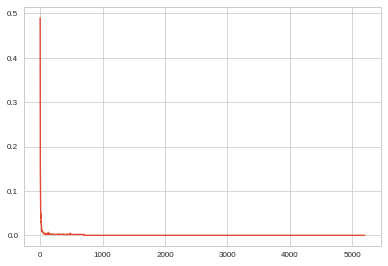

In [ ]:
#@title ### Plot of Loss Values { form-width: "30%" }

compression = 10

loss = np.ndarray.flatten(loss_values)
loss = np.nanmean(np.pad(loss.astype(float), (0, compression - loss.size%compression), mode='constant', constant_values=np.NaN).reshape(-1, compression), axis=1)
plt.plot(loss)
plt.yscale('log')

In [ ]:
#@title ### Validation { form-width: "30%" }

pred_list = []
true_values = []
valid_loss=0
c=0
for databatch in tqdm(parsed_valid_dataset):

    target = databatch[1]
    true_values.append(target.numpy())

    predictions = model(databatch[0],train_mode=False)
    pred_list.append(np.squeeze(predictions.numpy()))

    #loss_value = tf.keras.losses.MeanSquaredError()(target,predictions).numpy()
    loss_value = loss_fn(target, predictions).numpy()
    valid_loss+= loss_value
    c+=1

    print('validation loss', valid_loss/c)


AttributeError: ignored

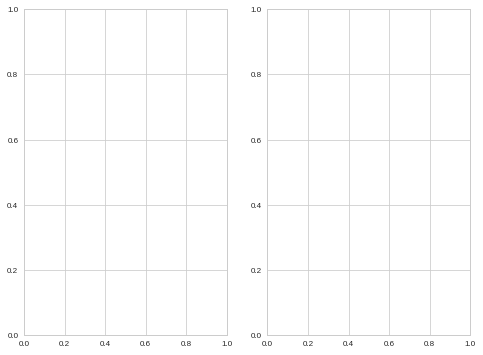

In [ ]:
#@title ### Plots of Outputs
#@markdown This is probably why there is a diagonal bias - mesh activation function?

fig, axs = plt.subplots(1,2, figsize=(8, 6), facecolor='w', edgecolor='k')  

axs = axs.ravel()
for pred_i in range(2):
    pred_vals = np.array([pp[:,:,pred_i] for pp in pred_list]).flatten()
    true_vals = np.array([tt[:,:,pred_i] for tt in true_values]).flatten()

    bin_means, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,bins=100)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    bin_stds, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,statistic='std',bins=100)


    axs[pred_i].plot(bin_centers,bin_means,c='C0')

    axs[pred_i].fill_between(bin_centers,bin_means-bin_stds,bin_means+bin_stds,color='C0',alpha=0.5)

    xx = np.linspace(true_vals.min(),true_vals.max(),10)
    axs[pred_i].plot(xx,xx,c='k',ls='--')

    axs[pred_i].set_ylabel('GNN prediction of parameter')
    axs[pred_i].set_xlabel('True parameter that generated the microstate')



#plt.savefig('gnn_' + str(run) + '.png',dpi=300)
#plt.show()

In [ ]:
#@title ### Rollout Function { form-width: "30%" }

INPUT_SEQUENCE_LENGTH=WINDOW_SIZE-1

KINEMATIC_PARTICLE_ID = 3
def get_kinematic_mask(particle_types):
  """Returns a boolean mask, set to true for kinematic (obstacle) particles."""
  return tf.equal(particle_types, KINEMATIC_PARTICLE_ID)

def rollout(simulator, features, num_steps):
  """Rolls out a trajectory by applying the model in sequence."""
  
  initial_positions = features['pos'][tf.newaxis,0:INPUT_SEQUENCE_LENGTH]
  initial_velocities = features['vel'][tf.newaxis,0:INPUT_SEQUENCE_LENGTH]
  initial_accelerations = features['acc'][tf.newaxis,0:INPUT_SEQUENCE_LENGTH]
  ground_truth_positions = features['pos'][tf.newaxis,INPUT_SEQUENCE_LENGTH:]
  ground_truth_velocities = features['vel'][tf.newaxis,INPUT_SEQUENCE_LENGTH:]
  ground_truth_accelerations = features['acc'][tf.newaxis,INPUT_SEQUENCE_LENGTH:]
  global_context = None
  
  def step_fn(step, current_positions, current_velocities, current_accelerations, pos_predictions, vel_predictions, acc_predictions):
    if global_context is None:
      global_context_step = None
    else:
      global_context_step = global_context[
          step + INPUT_SEQUENCE_LENGTH - 1][tf.newaxis]

    next_acceleration = simulator((current_positions,
                               current_velocities,
                               current_accelerations)
                    )
    next_velocity = next_acceleration*dt+current_velocities[:,-1]
    next_velocity /= tf.expand_dims(tf.norm(next_velocity, axis=-1),-1)
    next_position = next_velocity*dt+current_positions[:,-1]
    next_position = tf.where(next_position<0, next_position+DOMAIN_SIZE, next_position)
    next_position = tf.where(next_position>DOMAIN_SIZE, next_position-DOMAIN_SIZE, next_position)
    #next_acceleration = (next_velocity - current_velocities[:,-1])/dt
    # Update kinematic particles from prescribed trajectory.
    kinematic_mask = get_kinematic_mask(tf.zeros(N))
    next_position_ground_truth = ground_truth_positions[:,step,:,:]
    next_velocity_ground_truth = ground_truth_velocities[:,step,:,:]
    next_acceleration_ground_truth = ground_truth_accelerations[:,step,:,:]
    next_position = tf.where(tf.expand_dims(kinematic_mask,-1), next_position_ground_truth,
                             next_position)
    next_velocity = tf.where(tf.expand_dims(kinematic_mask,-1), next_velocity_ground_truth,
                             next_velocity)
    next_acceleration = tf.where(tf.expand_dims(kinematic_mask,-1), next_acceleration_ground_truth,
                             next_acceleration)
    updated_pos_predictions = pos_predictions.write(step, next_position)
    updated_vel_predictions = vel_predictions.write(step, next_velocity)
    updated_acc_predictions = acc_predictions.write(step, next_acceleration)
    # Shift `current_positions`, removing the oldest position in the sequence
    # and appending the next position at the end.
    next_positions = tf.concat([current_positions[:,1:,:,:],
                                next_position[:,tf.newaxis,:,:]], axis=1)
    next_velocities = tf.concat([current_velocities[:,1:,:,:],
                                next_velocity[:,tf.newaxis,:,:]], axis=1)
    next_accelerations = tf.concat([current_accelerations[:,1:,:,:],
                                next_acceleration[:,tf.newaxis,:,:]], axis=1)
  
    return (step + 1, next_positions, next_velocities, next_accelerations, updated_pos_predictions, updated_vel_predictions, updated_acc_predictions)
  
  pos_predictions = tf.TensorArray(size=num_steps, dtype=tf.float32)
  vel_predictions = tf.TensorArray(size=num_steps, dtype=tf.float32)
  acc_predictions = tf.TensorArray(size=num_steps, dtype=tf.float32)

  _, _, _, _, pos_predictions, vel_predictions, acc_predictions = tf.while_loop(
      cond=lambda step, state, vel, acc, pos_prediction, vel_prediction, acc_prediction: tf.less(step, num_steps),
      body=step_fn,
      loop_vars=(0, initial_positions, initial_velocities, initial_accelerations, pos_predictions, vel_predictions, acc_predictions),
      parallel_iterations=1)
  
  #pos_predictions = tf.transpose(pos_predictions, perm=[1,0,2,3])

  output_dict = {
      'initial_positions': initial_positions,
      'initial_velocities': initial_velocities,
      'initial_accelerations': initial_accelerations,
      'pos_predicted_rollout': pos_predictions.stack(),
      'vel_predicted_rollout': vel_predictions.stack(),
      'acc_predicted_rollout': acc_predictions.stack(),
      'ground_truth_position_rollout': ground_truth_positions,
      'ground_truth_velocity_rollout': ground_truth_velocities,
      'ground_truth_acceleration_rollout': ground_truth_accelerations
  }

  
  for field in ['pos_predicted_rollout','vel_predicted_rollout','acc_predicted_rollout']:
    output_dict[field]=tf.transpose(output_dict[field], perm=[1,0,2,3])


  if global_context is not None:
    output_dict['global_context'] = global_context
  return output_dict

In [ ]:
#@title ### Create Rollout Data { form-width: "30%" }

valid_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([valid_dir + filename for filename in os.listdir(valid_dir)]))

parsed_rollout_dataset = valid_dataset.map(_parse_record)
parsed_rollout_dataset = parsed_rollout_dataset.map(_parse_tensor)

for databatch in parsed_rollout_dataset:
    num_steps = databatch['pos'].shape[0]-INPUT_SEQUENCE_LENGTH
    output = rollout(model,databatch,num_steps)
    break

#output['metadata'] = metadata
filename = '/zonal_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(output, file)

/usr/local/lib/python3.7/dist-packages/spektral/layers/convolutional/conv.py:94: UserWarning: The adjacency matrix of dtype <dtype: 'int64'> is incompatible with the dtype of the node features <dtype: 'float32'> and has been automatically cast to <dtype: 'float32'>.
  f"The adjacency matrix of dtype {a.dtype} is incompatible with the dtype "


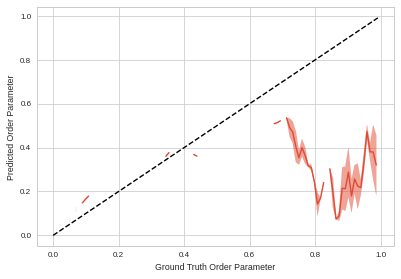

In [ ]:
#@title ### Order Parameter Plot

pred_av_velocity = np.mean(output['vel_predicted_rollout'][0,...],axis=1)
true_av_velocity = np.mean(output['ground_truth_velocity_rollout'][0,...],axis=1)
pred_std = np.std(output['vel_predicted_rollout'][0,...],axis=1)
true_std = np.std(output['ground_truth_velocity_rollout'][0,...],axis=1)

pred_order_parameter = np.linalg.norm(pred_av_velocity,axis=1)/vs
true_order_parameter = np.linalg.norm(true_av_velocity,axis=1)/vs

line = np.linspace(0,max(pred_order_parameter),10)
#plt.scatter(true_order_parameter, pred_order_parameter)
#plt.plot(line, line)

order = np.argsort(true_order_parameter)
true_order_parameter = true_order_parameter[order]
pred_order_parameter = pred_order_parameter[order]

bin_means, bin_edges, binnumber = stats.binned_statistic(true_order_parameter, pred_order_parameter,bins=100)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

bin_stds, bin_edges, binnumber = stats.binned_statistic(true_order_parameter, pred_order_parameter,statistic='std',bins=100)
max_val=max([np.amax(pred_order_parameter), np.amax(true_order_parameter)])
xx = np.linspace(0,max_val,10)
plt.plot(bin_centers,bin_means,c='C0')
plt.plot(xx,xx,c='k',ls='--')
plt.xlabel("Ground Truth Order Parameter")
plt.ylabel("Predicted Order Parameter")
plt.fill_between(bin_centers,bin_means-bin_stds,bin_means+bin_stds,color='C0',alpha=0.5)


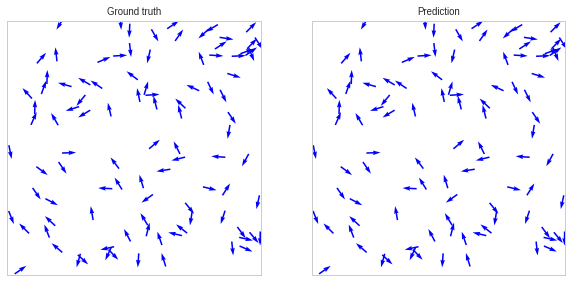

In [ ]:
#@title ### Render Rollouts

TYPE_TO_COLOR = {
    3: "black",  # Boundary particles.
    0: "green",  # Rigid solids.
    7: "magenta",  # Goop.
    6: "gold",  # Sand.
    5: "blue",  # Water.
}

step_stride = 3
block_on_show = True

with open(filename, "rb") as file:
  rollout_data = pickle.load(file)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plot_info = []
Q={}
for ax_i, (label, (rollout_field_1, rollout_field_2)) in enumerate(
    [("Ground truth", ("ground_truth_position_rollout", "ground_truth_velocity_rollout")),
      ("Prediction", ("pos_predicted_rollout", "vel_predicted_rollout"))]):
  # Append the initial positions to get the full trajectory.
  pos_trajectory = np.concatenate([
      rollout_data["initial_positions"][0,...],
      rollout_data[rollout_field_1][0,...]], axis=0)
  vel_trajectory = np.concatenate([
      rollout_data["initial_velocities"][0,...],
      rollout_data[rollout_field_2][0,...]], axis=0)
  ax = axes[ax_i]
  ax.set_title(label)
  bounds = [(0,DOMAIN_SIZE), (0,DOMAIN_SIZE)]
  ax.set_xlim(bounds[0][0], bounds[0][1])
  ax.set_ylim(bounds[1][0], bounds[1][1])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_aspect(1.)
  points = {
      particle_type: ax.plot([], [], "o", ms=2, color=color)[0]
      for particle_type, color in TYPE_TO_COLOR.items()}
  X, Y, U, V = pos_trajectory[0,:,0], pos_trajectory[0,:,1], vel_trajectory[0,:,0], vel_trajectory[0,:,1]
  Q[f'{ax_i}'] = ax.quiver(X, Y, U, V, pivot='mid', color='b', units='inches')
  plot_info.append((ax, pos_trajectory, vel_trajectory, points))


num_steps = pos_trajectory.shape[0]
#print(pos_trajectory.shape)

def update_quiver(num):
  for i, (ax, pos_trajectory, vel_trajectory, _) in enumerate(plot_info):
    U, V = vel_trajectory[num,:,0], vel_trajectory[num,:,1]
    offsets = pos_trajectory[num]

    Q[f'{i}'].set_offsets(offsets)
    Q[f'{i}'].set_UVC(U,V)
  return axes

anim = animation.FuncAnimation(fig, update_quiver,
                               interval=50, frames=np.arange(0, num_steps, step_stride),blit=False)
#plt.show(block=block_on_show)
rc('animation', html='jshtml')
anim


In [ ]:
_, allpos, allvel, _ = plot_info[1]
#allvel = simulation_cls.micro_state[0,:,:,2:]
        
X, Y = allpos[0,:,0],allpos[0,:,1]
U, V = allvel[0,:,0],allvel[0,:,1]
skip=50
fig, ax = plt.subplots(1,1,figsize=(8,8))
plt.close()
Q = ax.quiver(X, Y, U, V, pivot='mid', color='b', units='inches')
ax.axis('equal')
ax.set_xlim(0,DOMAIN_SIZE)
ax.set_ylim(0,DOMAIN_SIZE)

def update_quiver(num, Q, X, Y):
    """updates the horizontal and vertical vector components by a
    fixed increment on each frame
    """
    U, V = allvel[num,:,0],allvel[num,:,1]
    offsets = allpos[num]

    Q.set_offsets(offsets)
    Q.set_UVC(U,V)

    return Q,

# you need to set blit=False, or the first set of arrows never gets
# cleared on subsequent frames
anim = animation.FuncAnimation(fig, update_quiver, fargs=(Q, X, Y),
                               interval=50, frames=num_steps,blit=False)

rc('animation', html='jshtml')
anim
